**Goal: Using the Kaggle Boston Airbnb dataset, I attempt to use sentiment analysis on written reviews to predict the numerical Airbnb rating. (SPOILER ALERT: It doesn't go very well)**

The Airbnb dataset has 3 csv files: "calendar.csv", "listings.csv", "reviews.csv". I first create an LSTM model in Keras and train it on the IMDB sentiment dataset. Then I use the trained model on the comments from "reviews.csv" to predict sentiment: either positive (1), or negative (0). Taking the average of these, I see how closely this correlates to the actual ratings, found in "listings.csv".

A couple things of note: the initial sentiment analysis is a classification task, whereas predicting the rating is really a regression task. My intention is to see how closely we can correlate these.

Also, since this is my first Kaggle submission, note that I really like functions. I primarily program in Spyder, so writing functions allows for easy and discrete code chunks, and makes debugging much easier.

In [1]:
import numpy as np
import pandas as pd
import os
import string
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Embedding, LSTM, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import datetime
import math

Using TensorFlow backend.


First, we load in the IMDB dataset. This is also available via `keras.datasets`, but it comes preprocessed and already encoded there. I want to also work on the preprocessing and cleaning, so I got it directly from the source: http://ai.stanford.edu/~amaas/data/sentiment/ The dataset has 50,000 reviews: 25,000 for the training set and 25,000 for the testing set. Each set is further divided into positive ('pos') and negative ('neg') reviews.

In [2]:
def clean_imdb(directory):
    '''
    Returns cleaned dataframe of IMDB reviews with columns ['review', 'sentiment']
    '''
    sentiment = {'neg': 0, 'pos': 1}
    df_columns = ['review', 'sentiment']
    reviews_with_sentiment = pd.DataFrame(columns = df_columns)
    for i in ('test', 'train'):
        for j in ('neg', 'pos'):
            file_path = directory + i + '/' + j
            for file in os.listdir(file_path):
                with open((file_path + '/' + file), 'r',
                          encoding = 'utf-8') as text_file:
                    text = text_file.read()
                review = pd.DataFrame([[text, sentiment[j]]],
                                      columns = df_columns)
                reviews_with_sentiment = reviews_with_sentiment.\
                                         append(review, ignore_index = True)
    return reviews_with_sentiment

directory = 'Data/IMDB/'
cleaned_imdb = clean_imdb(directory)

Let's take a look at what a single review with sentiment looks like:

In [3]:
cleaned_imdb.iloc[13]

review       Man with the Screaming Brain is a story of gre...
sentiment                                                    0
Name: 13, dtype: object

Next we will load in one of the GloVe word embeddings (https://nlp.stanford.edu/projects/glove/). A word embedding represents words as vectors, which allows them to actually be interpreted by a computer. There are several different versions of GloVe depending on how many dimensions - and therefore memory - you would like to use. I used one of the smaller ones, with 50 dimensions and 6 billion tokens.

In [4]:
def load_GloVe(file_path):
    '''
    Loads word embedding .txt file
    Returns word embedding as dictionary
    '''
    GloVe_dict = dict()
    with open(file_path, encoding = 'utf-8') as GloVe_file:
        for line in GloVe_file:
            values = line.split()
            word = values[0]
            coef = np.asarray(values[1:], dtype = 'float32')
            GloVe_dict[word] = coef
    return GloVe_dict

GloVe_file_path = 'Data/glove.6B.50d.txt'
embedding_dict = load_GloVe(GloVe_file_path)

Let's check out this word embedding a bit. You can see that it includes 400,000 entries of all lower case words. We'll also look at a random slice of the `embedding_dict` keys.

In [5]:
len(embedding_dict)

400000

In [6]:
[print(word) for word in list(embedding_dict.keys()) if word != word.lower()]

[]

In [7]:
list(embedding_dict.keys())[100:125]

['so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 'between',
 'did',
 'just',
 'national',
 'day',
 'country',
 'under']

Let's check out how `'under'`, the last word in our list we just printed, is represented in vector space.

In [8]:
embedding_dict['under']

array([ 1.3721e-01, -2.9500e-01, -5.9160e-02, -5.9235e-01,  2.3010e-02,
        2.1884e-01, -3.4254e-01, -7.0213e-01, -5.5748e-01, -7.8537e-01,
        4.6417e-01,  4.4733e-01, -7.4178e-01, -4.6287e-01,  4.2665e-01,
        3.9795e-01, -2.1767e-01,  2.6260e-02, -3.1353e-01,  7.8520e-02,
        2.8495e-01,  1.1671e-01,  2.9981e-01, -9.1376e-01, -4.7744e-01,
       -1.6573e+00,  7.4029e-03, -1.1224e-01, -1.0604e-01,  2.9894e-01,
        3.4634e+00, -2.9341e-01, -7.6777e-01, -3.0120e-01, -3.7192e-03,
        2.3122e-01,  4.7334e-01,  1.3078e-01,  5.0225e-02,  1.9911e-01,
       -5.0179e-01, -3.4197e-03,  3.8654e-01,  5.7375e-02, -1.0157e+00,
       -3.3991e-01, -6.1970e-01, -5.9706e-01, -1.1377e-01, -6.4195e-01],
      dtype=float32)

Now that we have our reviews with sentiment and our word embedding loaded, it's time to start cleaning up and preprocessing our reviews. The reviews have all sorts of non-alphanumeric and uppercase characters, as shown in this rather eloquent review:

In [9]:
cleaned_imdb.iloc[489].values

array(['I was lucky enough to grow up surfing in San Diego (not the biggest waves in the world but it was a hell of childhood, I\'ll tell you that) and I have seen A LOT of so-called surfer flicks in my life. After watching NORTH SHORE for the first time just now, all I can say is THANK GOD I never saw this as a kid. If I had seen this and mistakenly thought that this was a realistic portrayal of the surf scene, I would sold my board and totally gotten into, I don\'t know, accounting or something.<br /><br />Seriously, this movie has a as much in common with real surfing as TOP GUN has was real military life. The acting is terrible, the music is worse, the cinematography is iffy at best and OH MY GOD what was Laird Hanilton thinking?! WOW!!! DO NOT SEE THIS MOVIE!!! IT SUCKS!!! If you want a REAL surf flick, see RIDING GIANTS. Hell, watch SURF\'S UP instead of this. Seriously. Sucks. Sucks bad. Sucks REAL bad. Brah. ;)<br /><br />PS: Had to change my summery from "WTF?!" to wtf because

Next, we will strip off all non-alphanumeric characters. This process takes a while, so I also added a print statement to update us on how far we've gotten. Note that while the `cleaned_imdb` reviews are a `pd.DataFrame`, this function is also used later when we are stripping the Airbnb reviews, which are a `pd.Series`, hence the `if` statement. We first strip off all the punctuation and replace it with a single space. Then we replace all whitespace characters, except actual spaces.

It's important to note that this is not always best practice. Consider the following sentence from the review above:

>WOW!!! DO NOT SEE THIS MOVIE!!! IT SUCKS!!!

You can tell that this carries a much stronger sentiment than just one (or no) exclamation points. There are ways of dealing with punctuation (see [VADER](https://github.com/cjhutto/vaderSentiment) for example), but I did not use them here.

In [10]:
def strip_punctuation_and_whitespace(reviews_df, verbose = True):
    '''
    Strips all punctuation and whitespace from reviews EXCEPT spaces (i.e. ' ')
    Removes "<br />"
    Returns dataframe of cleaned IMDB reviews
    '''
    trans_punc = str.maketrans(string.punctuation,
                               ' ' * len(string.punctuation))
    whitespace_except_space = string.whitespace.replace(' ', '')
    trans_white = str.maketrans(whitespace_except_space,
                                ' ' * len(whitespace_except_space))
    stripped_df = pd.DataFrame(columns = ['review', 'sentiment'])
    for i, row in enumerate(reviews_df.values):
        if i % 5000 == 0 and verbose == True:
            print('Stripping review: ' + str(i) + ' of ' + str(len(reviews_df)))
        if type(reviews_df) == pd.DataFrame:
            review = row[0]
            sentiment = row[1]
        elif type(reviews_df) == pd.Series:
            review = row
            sentiment = np.NaN
        try:
            review.replace('<br />', ' ')
            for trans in [trans_punc, trans_white]:
                review = ' '.join(str(review).translate(trans).split())
            combined_df = pd.DataFrame([[review, sentiment]],
                                       columns = ['review', 'sentiment'])
            stripped_df = pd.concat([stripped_df, combined_df],
                                    ignore_index = True)
        except AttributeError:
            continue
    return stripped_df

stripped_imdb = strip_punctuation_and_whitespace(cleaned_imdb)

Stripping review: 0 of 50000
Stripping review: 5000 of 50000
Stripping review: 10000 of 50000
Stripping review: 15000 of 50000
Stripping review: 20000 of 50000
Stripping review: 25000 of 50000
Stripping review: 30000 of 50000
Stripping review: 35000 of 50000
Stripping review: 40000 of 50000
Stripping review: 45000 of 50000


Now let's take another look at our surfer's review from above:

In [11]:
stripped_imdb.iloc[489].values

array(['I was lucky enough to grow up surfing in San Diego not the biggest waves in the world but it was a hell of childhood I ll tell you that and I have seen A LOT of so called surfer flicks in my life After watching NORTH SHORE for the first time just now all I can say is THANK GOD I never saw this as a kid If I had seen this and mistakenly thought that this was a realistic portrayal of the surf scene I would sold my board and totally gotten into I don t know accounting or something br br Seriously this movie has a as much in common with real surfing as TOP GUN has was real military life The acting is terrible the music is worse the cinematography is iffy at best and OH MY GOD what was Laird Hanilton thinking WOW DO NOT SEE THIS MOVIE IT SUCKS If you want a REAL surf flick see RIDING GIANTS Hell watch SURF S UP instead of this Seriously Sucks Sucks bad Sucks REAL bad Brah br br PS Had to change my summery from WTF to wtf because apparently we are supposed to whisper on this site NO 

We are going to need to know how many words we want to include in our tokenizer, so let's see how many words are in each review.

In [12]:
def get_length_all_reviews(sentences):
    '''
    Returns a list of length of all reviews
    Used for plotting histogram
    '''
    lengths = [len(i.split(' ')) for i in sentences]
    return lengths

imdb_lengths = get_length_all_reviews(stripped_imdb['review'])

In [13]:
max(imdb_lengths)

2525

Is that a lot of words or not? Let's plot a histogram and see where the majority of reviews are in terms of length. We can tell from the first plot below that 2525 is an outlier, so we also plot up to 1200 to get a better view.

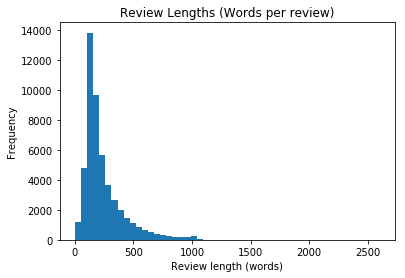

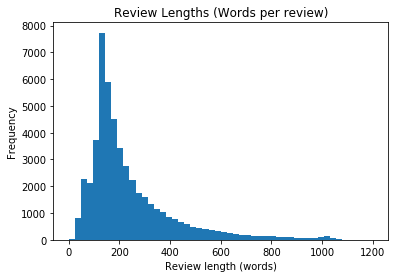

In [14]:
def plot_histogram(sentence_lengths, x_dim):
    '''
    Plots histogram of length of all sentences
    '''
    plt.hist(sentence_lengths, 50, [0, x_dim])
    plt.xlabel('Review length (words)')
    plt.ylabel('Frequency')
    plt.title('Review Lengths (Words per review)')
    plt.show()

plot_histogram(imdb_lengths, 2600)
plot_histogram(imdb_lengths, 1200)

From these plots, it's obvious the 2525 was an outlier, so we will choose a maximum sequence length of 1000 for our tokenizer. Additionally, we will use a `vocabulary_length` of 10,000. By setting `lower = True` within the `Tokenizer` object, we ensure that all words fed to the tokenizer are converted to lowercase. In practice, this may not always be the best idea. Consider the same sentence we looked at above:

>WOW!!! DO NOT SEE THIS MOVIE!!! IT SUCKS!!!

Once again, this clearly carries a stronger sentiment than if it had been written in all lowercase. However, the GloVe model we are using only recognizes lowercase words, so we force all words into lowercase.

In [15]:
def create_tokenizer(max_words_to_keep, words_review_df):
    '''
    Creates tokenizer
    Returns a tokenizer object and reviews converted to integers
    '''
    tokenizer = Tokenizer(num_words = max_words_to_keep,
                          lower = True,
                          split = ' ')
    tokenizer.fit_on_texts(words_review_df['review'].values)
    return tokenizer, \
           tokenizer.texts_to_sequences(words_review_df['review'].values)

imdb_sequence_length = 1000
vocabulary_length = 10000
tokenizer, integer_reviews = create_tokenizer(vocabulary_length, stripped_imdb)

And now looking at the same surfer review, converted to integers:

In [16]:
integer_reviews[489]

[10,
 14,
 1986,
 195,
 5,
 2106,
 56,
 4961,
 9,
 2872,
 9169,
 24,
 1,
 1123,
 4837,
 9,
 1,
 177,
 19,
 8,
 14,
 3,
 585,
 4,
 1649,
 10,
 233,
 379,
 21,
 12,
 2,
 10,
 28,
 109,
 3,
 172,
 4,
 37,
 438,
 1461,
 9,
 59,
 114,
 101,
 150,
 2169,
 5453,
 17,
 1,
 88,
 58,
 42,
 148,
 31,
 10,
 51,
 133,
 6,
 1341,
 503,
 10,
 113,
 211,
 11,
 15,
 3,
 524,
 46,
 10,
 68,
 109,
 11,
 2,
 193,
 12,
 11,
 14,
 3,
 800,
 1106,
 4,
 1,
 7166,
 131,
 10,
 61,
 2990,
 59,
 1786,
 2,
 459,
 1950,
 84,
 10,
 89,
 22,
 120,
 41,
 139,
 7,
 7,
 611,
 11,
 16,
 47,
 3,
 15,
 74,
 9,
 1104,
 18,
 146,
 4961,
 15,
 344,
 987,
 47,
 14,
 146,
 1279,
 114,
 1,
 115,
 6,
 380,
 1,
 207,
 6,
 432,
 1,
 628,
 6,
 32,
 119,
 2,
 425,
 59,
 503,
 48,
 14,
 535,
 1315,
 79,
 24,
 66,
 11,
 16,
 8,
 1685,
 46,
 21,
 182,
 3,
 146,
 7166,
 489,
 66,
 3093,
 6999,
 585,
 104,
 7166,
 13,
 56,
 303,
 4,
 11,
 611,
 1685,
 1685,
 75,
 1685,
 146,
 75,
 7,
 7,
 6049,
 68,
 5,
 660,
 59,
 38,
 6219,
 5,
 6219,
 

However, the reviews are all still different lengths:

In [17]:
print(len(integer_reviews[100]))
print(len(integer_reviews[200]))

101
120


We are going to need to ensure all the reviews are the same length when we ultimately feed it to our LSTM model. There are primarily 2 ways of doing this: pad `0` at the front (`pre`) of your sequence or at the end (`post`) of your sequence. Since an LSTM model forgets a little bit of it's training during each step, we will pad the `0`'s at the front of our sequence, ensuring most of the information is carried through the model.

In [18]:
def pad_zeros(encoded_reviews, padding_length, padding = 'pre'):
    '''
    Pads integer reviews either left ('pre') or right ('post')
    '''
    return pad_sequences(encoded_reviews,
                         maxlen = padding_length,
                         padding = padding)

padded_reviews = pad_zeros(integer_reviews,
                           imdb_sequence_length,
                           padding = 'pre')

Once again, same review, now with `0` padding at the start of the review

In [19]:
padded_reviews[489]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

We are finally ready to start training out LSTM model. Before we do that, let's recap what we've done to get us this far:

* We loaded in our IMDB dataset, which has 25,000 positive and 25,000 negative reviews. Each of the reviews is assigned their respective sentiment (negative = 0, positive = 1). We loaded these all into one dataframe, `cleaned_imdb`.
* We loaded our GloVe model as `embedding_dict`, which has 400,000 lowercase words. Each of these words is mapped to a 50-dimensional vector space.
* We stripped all punctuation and extra whitespace from the IMDB reviews and created the `stripped_imdb` dataframe. This allows us to actually represent the words within the reviews in the vector space given by the GloVe model.
* By plotting a histogram of the length of each of the IMDB reviews, we were able to determine an appropriate maximum length to feed our `tokenizer`. This prevents it from having to carry around a bunch of `0`'s just to match the length of one very wordy review.
* We converted the words in each review to integers and captured them in the list `integer_reviews`. Computers like numbers a lot more than words, so this will allow our model to actually train on the reviews.
* Finally, we padded `0`'s at the beginning of every review - up to our `imdb_sequence_length` of 1000 - determined from our histogram plot and created the array `padded_reviews`

Great! Now we can start creating and training our LSTM model. First, we will need to split our `padded_reviews` array into training and testing sets. We split it right in half, but you can adjust this to have more or less samples captured in your testing set. We've also set the `random_state` for reproducibility.

In [20]:
split = 0.5
X_train, X_test, y_train, y_test = train_test_split(padded_reviews,
                                                    stripped_imdb['sentiment'],
                                                    test_size = split,
                                                    random_state = 42)

In [21]:
def create_LSTM_model(vocab_length, in_length, opt = 'Adam',
                      learning_rate = 0.001):
    '''
    Returns 1-layer LSTM model
    '''
    model = Sequential()
    model.add(Embedding(vocab_length, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = getattr(keras.optimizers, opt)(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

LSTM_model = create_LSTM_model(vocabulary_length,
                               imdb_sequence_length,
                               opt = 'Adam',
                               learning_rate = 0.001)
print(LSTM_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
None


This is about as simple an LSTM model as one can make, but before we try to complicate matters, let's see how well it performs. We will save the training performance in `LSTM_history` to reference after training.

In [22]:
ep = 10
LSTM_history = LSTM_model.fit(X_train, y_train,
                              validation_data = (X_test, y_test),
                              batch_size = 1000, epochs = ep, verbose = 1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 1252s 50ms/step - loss: 0.6890 - acc: 0.5720 - val_loss: 0.6783 - val_acc: 0.6598
Epoch 2/10
25000/25000 [==============================] - 1240s 50ms/step - loss: 0.5796 - acc: 0.7380 - val_loss: 0.4618 - val_acc: 0.8138
Epoch 3/10
25000/25000 [==============================] - 1201s 48ms/step - loss: 0.3935 - acc: 0.8437 - val_loss: 0.3802 - val_acc: 0.8354
Epoch 4/10
25000/25000 [==============================] - 1214s 49ms/step - loss: 0.3006 - acc: 0.8855 - val_loss: 0.3147 - val_acc: 0.8723
Epoch 5/10
25000/25000 [==============================] - 1213s 49ms/step - loss: 0.2257 - acc: 0.9182 - val_loss: 0.3119 - val_acc: 0.8794
Epoch 6/10
25000/25000 [==============================] - 1187s 47ms/step - loss: 0.1854 - acc: 0.9369 - val_loss: 0.3039 - val_acc: 0.8834
Epoch 7/10
25000/25000 [==============================] - 1195s 48ms/step - loss: 0.1637 - acc: 0.9482 - val_l

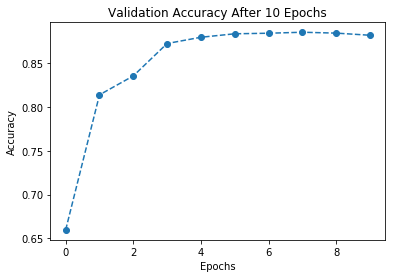

In [23]:
plt.plot(range(10), LSTM_history.history['val_acc'], '--o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy After {} Epochs'.format(ep))
plt.show()

Looks like we hit our maximum accuracy of ~88% after only 4 epochs! This is without any optimization of hyperparameters whatsoever, and one of the simplest LSTM models you can put together. Since this is only an exploration to see if we can correlate sentiment with actual ratings, this accuracy is sufficient for now. We could easily go back and alter any of the hyperparameters, add more layers to the model, etc. if we so desire.

Now, finally on to the fun part! Let's see how well this model can predict the sentiment on the Airbnb reviews. First, we'll load in the datasets.

In [25]:
def load_airbnb_datasets():
    '''
    Run this if you need to load in the Boston Airbnb datasets
    '''
    df_calendar = pd.read_csv('./Data/calendar.csv')
    df_listings = pd.read_csv('./Data/listings.csv')
    df_reviews = pd.read_csv('./Data/reviews.csv')
    return df_calendar, df_listings, df_reviews

df_calendar, df_listings, df_reviews = load_airbnb_datasets()

Let's see how these are broken down.

In [26]:
df_reviews.iloc[13]

listing_id                                                 1178162
id                                                         8414572
date                                                    2013-10-29
reviewer_id                                                 478275
reviewer_name                                                  Kat
comments         Well sized room for two people with the basic ...
Name: 13, dtype: object

Ok, so `df_reviews` has both a `listing_id` and a review in the `comments` column. We will use these to match the reviews up to the listings. Let's see how `df_listings` is setup.

In [27]:
df_listings.iloc[13]

id                                                                           13547301
listing_url                                     https://www.airbnb.com/rooms/13547301
scrape_id                                                              20160906204935
last_scraped                                                               2016-09-07
name                                                    2 Bedroom Apartment in Boston
summary                             My place is close to Public Transportation. Th...
space                                                                             NaN
description                         My place is close to Public Transportation. Th...
experiences_offered                                                              none
neighborhood_overview                                                             NaN
notes                                                                             NaN
transit                                               

The listings have a ton more information, but all we are going to focus on for this exploration are the `id` and `review_scores_rating`. By matching up the `listing_id` in `df_reviews` with the `id` in `df_listings`, we can try to correlate an average sentiment calculated from our model with the `review_scores_rating`.

First, let's see how many reviews a single listing might have. We need to have some threshold so that we can try to apply the central limit theorem.

In [28]:
ids, counts = np.unique(df_reviews['listing_id'], return_counts = True)
print('Minimum number of reviews: ' + str(min(counts)))
print('Maximum number of reviews: ' + str(max(counts)))

Minimum number of reviews: 1
Maximum number of reviews: 404


Ok...so this is a pretty big range. In theory, we could make a `for` loop, run from 1 to 404 and see when (if?) we approach a good approximation. For now, let's make a somewhat arbitrary cutoff and only look at listings that have at least 100 reviews. If we want, we can come back later and experiment with this.

In [29]:
gt_100 = np.where(counts > 100)[0]
ids_gt_100 = ids[gt_100]

print('Number of listings with greater than 100 reviews: ' + str(len(gt_100)))
print('\nIndices of listings with greater than 100 reviews:\n' + str(gt_100))
print('\nAssociated listings with greater than 100 reviews:\n' + str(ids_gt_100))

Number of listings with greater than 100 reviews: 133

Indices of listings with greater than 100 reviews:
[  24   29   30   39   40   46   56   58   60   66   69   72   78   80
   83   94   95   96   97   99  101  102  110  116  119  126  128  134
  135  137  142  144  146  153  154  166  181  185  189  200  203  204
  222  231  239  240  242  245  246  248  249  252  256  257  280  282
  284  296  307  311  312  315  319  322  327  330  334  343  360  361
  363  368  378  379  380  389  400  417  426  434  446  479  482  491
  493  514  520  535  536  548  551  566  601  617  630  638  669  674
  677  678  679  680  686  702  704  746  747  757  810  817  826  848
  860  867  869  883  887  893  914  991 1026 1039 1054 1075 1085 1086
 1121 1182 1197 1224 1241 1394 1698]

Associated listings with greater than 100 reviews:
[  20000   22354   23619   31796   36885   47521   57800   60029   66288
   72811   77691   93505  163941  169430  177129  197972  200265  205894
  210097  217498  22

We now have everything we need:

* LSTM model with relatively good accuracy
* Listing IDs of Airbnbs with greater than 100 reviews

Let's start analyzing these reviews! We create a `for` loop to run through each of the listing IDs in `ids_gt_100`, find them in the `df_reviews` dataframe, and then run through the exact same sequence of preprocessing as we did for the IMDB dataset - makes it helpful that we defined all of these functions above. At the end, however, instead of training a model, we use our `LSTM_model` to make predictions of sentiment and collect them in a `ratings` dictionary. The `ratings` dictionary will have the `listing_id` as the key (which we call `temp_id` in the loop), and a list of `[actual_rating, predicted_rating]` as the values.

One thing I will note, I chose an `airbnb_sequence_length` of 250, as opposed to the `imdb_sequence_length` of 1000. When I ran this through originally, I plotted similar histograms to the IMDB dataset of each of the listing IDs, and found 250 was a pretty consistent cutoff in terms of length. I don't want to include 133 histograms in this notebook, but you can feel free to uncomment the following line of code in the `for` loop and see for yourself (also feel free to adjust 1000 to whatever you'd like):

`plot_histogram(airbnb_lengths, 1000)`

In [30]:
ratings = {}

for temp_id in ids_gt_100:
    temp_comments = df_reviews.loc[df_reviews['listing_id'] == \
                                   temp_id]['comments']
    
    # Rename for function, then strip punctuation and whitespace
    temp_comments.rename('review', inplace = True)
    stripped_airbnb = strip_punctuation_and_whitespace(temp_comments,
                                                       verbose = False)
    
    # Plot histogram of review length. Find sequence cutoff length
    airbnb_lengths = get_length_all_reviews(stripped_airbnb['review'])
    #plot_histogram(airbnb_lengths, 1000)
    airbnb_sequence_length = 250
    
    # Tokenizer with 10000 word vocabulary
    airbnb_tokenizer, airbnb_integer_reviews = \
                                            create_tokenizer(vocabulary_length,
                                                             stripped_airbnb)
    # Pad zeros up to airbnb_sequence_length
    airbnb_padded_reviews = pad_zeros(airbnb_integer_reviews,
                                      airbnb_sequence_length,
                                      padding = 'pre')
    
    # Predict sentiment
    airbnb_sentiments = LSTM_model.predict_classes(airbnb_padded_reviews)
    predicted_rating = round(airbnb_sentiments.mean() * 100, 1)

    # Print comparisons
    actual_rating = df_listings.loc[df_listings['id'] == temp_id]\
                    ['review_scores_rating'].values[0]
    print('--- Listing ID ' + str(temp_id) + ' ---\nPredicted Rating: [' + \
          str(predicted_rating) + '] vs. Actual Rating: [' + \
          str(actual_rating) + ']')
    ratings[temp_id] = [actual_rating, predicted_rating]

--- Listing ID 20000 ---
Predicted Rating: [49.8] vs. Actual Rating: [86.0]
--- Listing ID 22354 ---
Predicted Rating: [48.8] vs. Actual Rating: [88.0]
--- Listing ID 23619 ---
Predicted Rating: [50.4] vs. Actual Rating: [92.0]
--- Listing ID 31796 ---
Predicted Rating: [48.3] vs. Actual Rating: [87.0]
--- Listing ID 36885 ---
Predicted Rating: [44.0] vs. Actual Rating: [97.0]
--- Listing ID 47521 ---
Predicted Rating: [47.7] vs. Actual Rating: [88.0]
--- Listing ID 57800 ---
Predicted Rating: [50.0] vs. Actual Rating: [90.0]
--- Listing ID 60029 ---
Predicted Rating: [51.8] vs. Actual Rating: [95.0]
--- Listing ID 66288 ---
Predicted Rating: [43.3] vs. Actual Rating: [78.0]
--- Listing ID 72811 ---
Predicted Rating: [42.3] vs. Actual Rating: [91.0]
--- Listing ID 77691 ---
Predicted Rating: [47.4] vs. Actual Rating: [88.0]
--- Listing ID 93505 ---
Predicted Rating: [44.0] vs. Actual Rating: [94.0]
--- Listing ID 163941 ---
Predicted Rating: [50.7] vs. Actual Rating: [92.0]
--- Listing

--- Listing ID 4314054 ---
Predicted Rating: [46.0] vs. Actual Rating: [87.0]
--- Listing ID 4359160 ---
Predicted Rating: [39.7] vs. Actual Rating: [75.0]
--- Listing ID 4553903 ---
Predicted Rating: [46.4] vs. Actual Rating: [94.0]
--- Listing ID 4568116 ---
Predicted Rating: [42.3] vs. Actual Rating: [96.0]
--- Listing ID 4586590 ---
Predicted Rating: [54.9] vs. Actual Rating: [98.0]
--- Listing ID 4695542 ---
Predicted Rating: [38.6] vs. Actual Rating: [85.0]
--- Listing ID 4765070 ---
Predicted Rating: [55.4] vs. Actual Rating: [93.0]
--- Listing ID 4793787 ---
Predicted Rating: [54.5] vs. Actual Rating: [98.0]
--- Listing ID 4820071 ---
Predicted Rating: [53.4] vs. Actual Rating: [95.0]
--- Listing ID 4909590 ---
Predicted Rating: [50.5] vs. Actual Rating: [97.0]
--- Listing ID 4924910 ---
Predicted Rating: [41.4] vs. Actual Rating: [87.0]
--- Listing ID 4967219 ---
Predicted Rating: [49.7] vs. Actual Rating: [82.0]
--- Listing ID 5085125 ---
Predicted Rating: [46.3] vs. Actual R

All right, so this...isn't great. Predicted Ratings aren't matching up that well with Actual Ratings. Let's make this visual just to see what exactly we're dealing with. First, we'll sort the ratings in ascending order of Actual Rating. Since we created a list of `[actual_rating, predicted_rating]` as the values in the `ratings` dictionary, we can easily sort them while also ensuring both ratings are still referring to the same `listing_id`. What we don't want to do is sort `actual_rating` and `predicted_rating` *separately* - if we did that, we would likely see a false correlation as both ratings would obviously increase.

In [31]:
sorted_ratings = [ratings[i] for i in ratings]
sorted_ratings.sort()
sorted_ratings

[[71.0, 44.6],
 [75.0, 39.7],
 [76.0, 45.7],
 [78.0, 43.3],
 [78.0, 49.4],
 [80.0, 42.6],
 [82.0, 49.7],
 [83.0, 42.1],
 [85.0, 38.6],
 [85.0, 43.3],
 [86.0, 41.9],
 [86.0, 47.8],
 [86.0, 48.1],
 [86.0, 49.8],
 [86.0, 54.0],
 [87.0, 41.4],
 [87.0, 45.0],
 [87.0, 45.0],
 [87.0, 45.8],
 [87.0, 46.0],
 [87.0, 46.5],
 [87.0, 46.8],
 [87.0, 48.3],
 [87.0, 50.3],
 [87.0, 51.5],
 [88.0, 41.8],
 [88.0, 46.3],
 [88.0, 47.4],
 [88.0, 47.7],
 [88.0, 48.1],
 [88.0, 48.5],
 [88.0, 48.8],
 [88.0, 48.8],
 [88.0, 52.0],
 [89.0, 48.2],
 [89.0, 49.6],
 [89.0, 50.0],
 [90.0, 42.7],
 [90.0, 46.3],
 [90.0, 50.0],
 [91.0, 40.0],
 [91.0, 42.3],
 [91.0, 46.8],
 [91.0, 48.6],
 [91.0, 50.3],
 [91.0, 50.4],
 [91.0, 51.6],
 [92.0, 40.9],
 [92.0, 44.5],
 [92.0, 47.0],
 [92.0, 48.3],
 [92.0, 49.7],
 [92.0, 50.4],
 [92.0, 50.4],
 [92.0, 50.7],
 [92.0, 51.1],
 [92.0, 52.4],
 [92.0, 52.6],
 [92.0, 53.4],
 [92.0, 54.3],
 [92.0, 55.1],
 [93.0, 42.9],
 [93.0, 42.9],
 [93.0, 45.8],
 [93.0, 49.0],
 [93.0, 49.4],
 [93.0, 53

Now, we can separate them feeling confident the ratings are in the correct order. You can easily match these lists up with the values above.

In [32]:
plot_actual_ratings = [rating[0] for rating in sorted_ratings]
plot_predicted_ratings = [rating[1] for rating in sorted_ratings]

print('First 10 Actual Ratings: \n' + str(plot_actual_ratings[0:10]))
print('\nFirst 10 Predicted Ratings: \n' + str(plot_predicted_ratings[0:10]))

First 10 Actual Ratings: 
[71.0, 75.0, 76.0, 78.0, 78.0, 80.0, 82.0, 83.0, 85.0, 85.0]

First 10 Predicted Ratings: 
[44.6, 39.7, 45.7, 43.3, 49.4, 42.6, 49.7, 42.1, 38.6, 43.3]


Lastly, we'll plot the ratings and see how well we did! Note that the y-axes do not display comparable ranges. Since the model gets trained differently each time we run through this, the predicted ratings tend to fluctuate, so we can't anticipate and set limits on the ranges. However, we want to show how ratings fluctuate within one dataset and see if any potential fluctuations are comparable, so this usually works to our advantage since the plots automatically get overlaid.

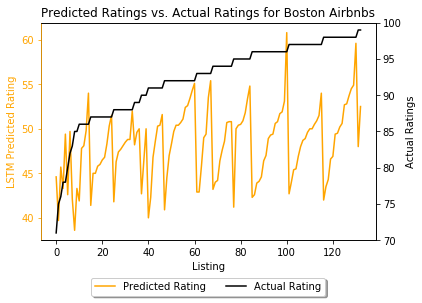

In [33]:
ax1_min = int(math.floor(min(plot_predicted_ratings)/5) * 5)

fig, ax1 = plt.subplots()
predicted_line = ax1.plot(range(len(plot_predicted_ratings)),
                          plot_predicted_ratings,
                          color = 'orange',
                          label = 'Predicted Ratings')
ax1.set_xlabel('Listing')
ax1.set_ylabel('LSTM Predicted Rating', color = 'orange')
ax1.tick_params(axis = 'y', color = 'orange')
plt.setp(ax1.get_yticklabels(), color = 'orange')

ax2 = ax1.twinx()
actual_line = ax2.plot(range(len(plot_actual_ratings)),
                       plot_actual_ratings,
                       color = 'black',
                       label = 'Actual Ratings')
ax2.set_ylabel('Actual Ratings', color = 'black')
ax2.set_ylim(70, 100)
ax2.spines['left'].set_color('orange')

ax1.legend((predicted_line + actual_line),
           ['Predicted Rating', 'Actual Rating'],
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.15),
           fancybox = True,
           shadow = True,
           ncol = 2)
plt.title('Predicted Ratings vs. Actual Ratings for Boston Airbnbs')
plt.show()

Obviously, this was a failed experiment. I'll be honest, it went a lot better in my head. However, it was a super fun exploration and I learned a lot about both LSTMs and presenting my info logically in a notebook. From a data analysis perspective, I don't think correlating a binary classifier (i.e. "positive" or "negative") with what should really be a regression task (predicting a numerical rating) was the best approach. However, I do think this can be used to show how differently people rate things when given a numerical assessment versus a verbal/written assessment.